In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the training data
df_path = 'data_files/Loan Prediction Problem Dataset train.csv'
df = pd.read_csv(df_path )
    

In [7]:
if not df.empty:
    print("--- First 5 Rows ---")
    print(df.head())
    
    print("\n--- Data Info ---")
    print(df.info())

--- First 5 Rows ---
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  

In [11]:
 # --- Check for Missing Data ---
print("\n--- Missing Values Count ---")
print(df.isnull().sum())


--- Missing Values Count ---
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


##### Feature Engineering & Preprocessing

In [13]:
if not df.empty:
    # --- 1. Handle Target Variable (y) ---
    # Convert Y/N to 1/0
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # --- 2. Handle Missing Categorical Data (Imputation) ---
    # We will fill with the 'mode' (most frequent value)
    df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
    df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
    df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
    df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
    
    # Credit_History is critical. Most are 1.0, so we'll use mode.
    df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
    
    # --- 3. Handle Missing Numerical Data (Imputation) ---
    # We will fill with the 'median' (robust to outliers)
    df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
    df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

    print("\n--- Missing Values After Imputation ---")
    print(df.isnull().sum())
    
    # --- 4. Feature Creation (Optional, but good) ---
    # Combine incomes to get a total income
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    
    # --- 5. Categorical Encoding (One-Hot Encoding) ---
    # We drop 'Loan_ID' as it's just an identifier
    df = df.drop('Loan_ID', axis=1)
    
    # Use pandas.get_dummies to convert all 'object' columns
    df_encoded = pd.get_dummies(df, drop_first=True)
    
    print("\n--- Final DataFrame Head (After Encoding) ---")
    print(df_encoded.head())
    print(f"\nFinal data shape: {df_encoded.shape}")


--- Missing Values After Imputation ---
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

--- Final DataFrame Head (After Encoding) ---
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0       128.0             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History  Loan_Status  Total_Income  Gender_Male  Married_Yes  \
0             1.0            1        5849.0         True        False   
1             1.0        

##### Model Building (Random Forest)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [16]:
if 'df_encoded' in locals():
    # 1. Define X and y
    X = df_encoded.drop('Loan_Status', axis=1)
    y = df_encoded['Loan_Status']
    
    # 2. Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3. Scale Numerical Features
    # Note: RandomForest doesn't strictly need this, but
    # Logistic Regression or SVM would. It's good practice.
    scaler = StandardScaler()
    
    # Identify numerical columns to scale (Total_Income, ApplicantIncome, etc.)
    # We'll just scale the ones we know are continuous
    num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income']
    
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    
    # 4. Train the Model
    print("\n--- Training Random Forest Classifier ---")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    print("Model training complete.")


--- Training Random Forest Classifier ---
Model training complete.


##### Model Evaluation


--- Model Evaluation ---
Accuracy: 78.86%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.44      0.59        43
           1       0.76      0.97      0.86        80

    accuracy                           0.79       123
   macro avg       0.83      0.71      0.73       123
weighted avg       0.81      0.79      0.77       123


Confusion Matrix:


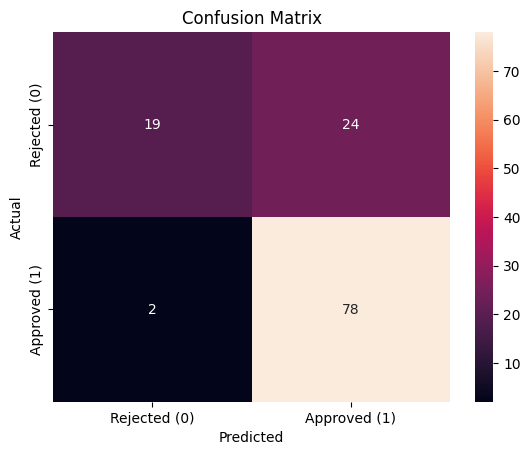

In [20]:
if 'model' in locals():
    # 5. Make Predictions
    y_pred = model.predict(X_test)
    
    # 6. Evaluate
    print("\n--- Model Evaluation ---")
    
    # Check Accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    
    # Check Classification Report (Precision, Recall, F1)
    # Class 0 = 'N' (Rejected), Class 1 = 'Y' (Approved)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Check Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['Rejected (0)', 'Approved (1)'], 
                yticklabels=['Rejected (0)', 'Approved (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()